# Imports

In [1]:
import matplotlib.pyplot as plt

import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform


random_seed = 1
torch.manual_seed(random_seed)

DATA_DIR = "C:\\Users\\Zayan\\Documents\\datasets\\time_image_classification"

# Time

This article shows how to prep data: https://www.kaggle.com/code/josemariasabater/it-s-all-about-time-simple-cnn-99-7-acc#Start-with-the-Neural-Network-part
This article shows how to build a model: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:
df = pd.read_csv('C:\\Users\\Zayan\\Documents\\datasets\\time_image_classification\\clocks.csv')

In [3]:
df.head()

,class index,filepaths,labels,data set
0,0,train/1-00/0.jpg,1_00,train
1,0,train/1-00/1.jpg,1_00,train
2,0,train/1-00/11.jpg,1_00,train
3,0,train/1-00/12.jpg,1_00,train
4,0,train/1-00/13.jpg,1_00,train


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  14400 non-null  int64 
 1   filepaths    14400 non-null  object
 2   labels       14400 non-null  object
 3   data set     14400 non-null  object
dtypes: int64(1), object(3)
memory usage: 450.1+ KB


In [5]:
num_classes = df['class index'].nunique() # number of classes
print(num_classes)

classes = df['class index'].unique()
print(classes[:5])

144
[0 1 2 3 4]


## Dataloader (Pytorch way)

This article explains everything: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
class TimeDataset(Dataset):
    '''
    Format of annotation:
    class index, filepaths, labels, data set
    0, train/1-00/0.jpg, 1_00, train
       '''
    def __init__(self, csv_file, root_dir, transform=None) -> None:
        self.root_dir = root_dir
        self.annotations = pd.read_csv(f"{root_dir}\\{csv_file}") # read csv file as pandas dataframe
        self.transform = transform

        self.annotations["labels"] = self.annotations["labels"].str.replace("_", ":") # replace _ with : in the time

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = io.imread(img_path)
        
        y_label = torch.tensor(int(self.annotations.iloc[index, 0]))
        time = self.annotations.iloc[index, 2]

        sample = {'image':image, 'label':y_label, 'time':time}

        if self.transform:
            sample['image'] = self.transform(sample["image"])

        return sample        

In [8]:
dataset = TimeDataset(csv_file='clocks.csv', root_dir=DATA_DIR, transform=transforms.ToTensor())

In [9]:
dataset[2]

{'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'label': tensor(0),
 'time': '1:00'}

0 torch.Size([3, 224, 224])
class: 0, Time: 1:00


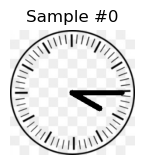

1 torch.Size([3, 224, 224])
class: 0, Time: 1:00


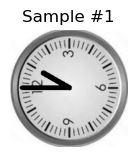

2 torch.Size([3, 224, 224])
class: 0, Time: 1:00


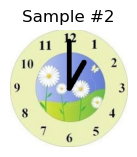

3 torch.Size([3, 224, 224])
class: 0, Time: 1:00


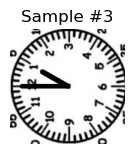

In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
fig = plt.figure()

for i, sample in enumerate(dataset):
    print(i, sample['image'].shape)
    print(f"class: {sample['label']}, Time: {sample['time']}")

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [10]:
K = len(dataset)
print(K)

14400


Train set and test set

In [11]:
train_set, test_set = torch.utils.data.random_split(dataset, [0.7, 0.3])

data loader

In [12]:
batch_size = 20
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

Study the training data, a sample and a batch

--------------TRAINING DATA----------------
len of training data = 10080
number of batches = 504
---------------SAMPLE--------------
len of a sample =  3
sample feature data:
{'image': tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922]],

        [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9922]],

   

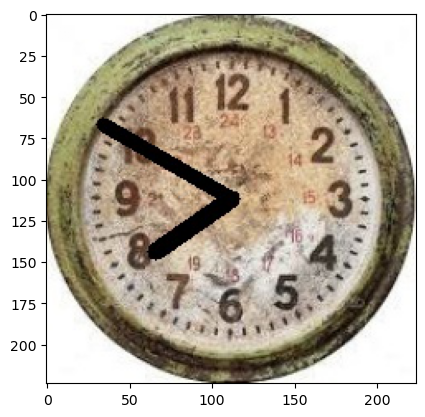

In [13]:
print("--------------TRAINING DATA----------------")
print("len of training data =", len(train_set))
print("number of batches =", len(train_loader)) # len(train_loader) produces the number of batches. Each item in train loader is a batch

print("---------------SAMPLE--------------")
print("len of a sample = ", len(train_set[0]))

print("sample feature data:")
print(train_set[0])

imshow(train_set[0]['image'])



-----------BATCH------------
{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
   

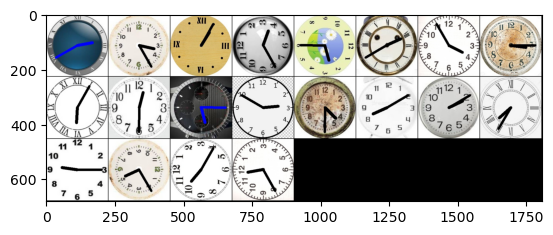

56 65 1 68 54 122 71 63 97 42 126 58 78 122 50 115 135 86 16 32


In [14]:
print("-----------BATCH------------")
batch_samples = next(iter(train_loader))
print(batch_samples)
print("batch size = ", len(batch_samples['image']))

print("--------------PLOT A BATCH-----------")
images = batch_samples['image']
labels = batch_samples['label']

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(batch_size)))

In [15]:
df[df['class index']==61]

,class index,filepaths,labels,data set
4880,61,train/3-05/0.jpg,3_05,train
4881,61,train/3-05/1.jpg,3_05,train
4882,61,train/3-05/10.jpg,3_05,train
4883,61,train/3-05/12.jpg,3_05,train
4884,61,train/3-05/13.jpg,3_05,train
...,...,...,...,...
13575,61,valid/3-05/47.jpg,3_05,valid
13576,61,valid/3-05/50.jpg,3_05,valid
13577,61,valid/3-05/51.jpg,3_05,valid
13578,61,valid/3-05/60.jpg,3_05,valid


In [16]:
for i, sample in enumerate(train_loader, 2):
    print(sample)
    if i==3:
        break

{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.000

{'image': tensor([[[[0.4980, 0.5333, 0.5608,  ..., 0.4157, 0.4118, 0.3882],
          [0.5176, 0.5451, 0.5686,  ..., 0.4078, 0.4039, 0.3843],
          [0.5373, 0.5647, 0.5765,  ..., 0.4039, 0.4000, 0.3843],
          ...,
          [0.5882, 0.5922, 0.5843,  ..., 0.6314, 0.6235, 0.6196],
          [0.5922, 0.5882, 0.5804,  ..., 0.6471, 0.6510, 0.6588],
          [0.5804, 0.5804, 0.5647,  ..., 0.6471, 0.6549, 0.6706]],

         [[0.2706, 0.3059, 0.3255,  ..., 0.1922, 0.1961, 0.1725],
          [0.2902, 0.3176, 0.3333,  ..., 0.1843, 0.1804, 0.1608],
          [0.3137, 0.3294, 0.3333,  ..., 0.1765, 0.1686, 0.1529],
          ...,
          [0.3490, 0.3490, 0.3333,  ..., 0.3569, 0.3490, 0.3451],
          [0.3490, 0.3451, 0.3255,  ..., 0.3725, 0.3765, 0.3843],
          [0.3451, 0.3373, 0.3216,  ..., 0.3725, 0.3804, 0.3882]],

         [[0.1765, 0.2118, 0.2314,  ..., 0.1137, 0.1176, 0.0941],
          [0.1961, 0.2235, 0.2314,  ..., 0.1059, 0.1059, 0.0863],
          [0.2078, 0.2275, 0.235

## CNN with pooling

This article has a basic model: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Manually coding layers and receptive fields

In [17]:
import torch
import torch.nn.functional as F

# Create a 255x255 tensor with random numbers
random_tensor = torch.rand((1, 1, 255, 255))

# Apply MaxPooling2D with kernel size 2
max_pooled_tensor = F.max_pool2d(random_tensor, kernel_size=2)

# Print the original and max-pooled tensors
print("Original Tensor:")
print(random_tensor.shape)
print("\nMax-Pooled Tensor:")
print(max_pooled_tensor.shape)


Original Tensor:
torch.Size([1, 1, 255, 255])

Max-Pooled Tensor:
torch.Size([1, 1, 127, 127])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a random 255x255 tensor with 3 channels (e.g., representing an RGB image)
input_tensor_large = torch.rand((1, 3, 255, 255))
print("Input Tensor Shape:", input_tensor_large.shape)

# Define a convolutional layer
conv_layer_large = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
output_tensor_large = conv_layer_large(input_tensor_large)
print("Convolutional Layer Output Shape:", output_tensor_large.shape)

# Apply maxpool2d with kernel size 2 and stride 2
max_pooled_tensor_large_1 = F.max_pool2d(output_tensor_large, kernel_size=2, stride=2)
print("MaxPool2d (kernel_size=2, stride=2) Output Shape:", max_pooled_tensor_large_1.shape)

# Define another convolutional layer
conv_layer_large_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
output_tensor_large_2 = conv_layer_large_2(max_pooled_tensor_large_1)
print("Second Convolutional Layer Output Shape:", output_tensor_large_2.shape)

# Apply maxpool2d with kernel size 2 and stride 2 after the second convolutional layer
max_pooled_tensor_large_2 = F.max_pool2d(output_tensor_large_2, kernel_size=2, stride=2)
print("Second MaxPool2d (kernel_size=2, stride=2) Output Shape:", max_pooled_tensor_large_2.shape)

# Flatten the output tensor before passing it through the linear layer
flattened_tensor_large = max_pooled_tensor_large_2.view(-1, 16 * 60 * 60)  # Adjust based on the spatial dimensions
print("Flattened Tensor Shape:", flattened_tensor_large.shape)

# Define a linear layer with 120 outputs
linear_layer_large = nn.Linear(in_features=16 * 60 * 60, out_features=144)  # Adjust based on the spatial dimensions
linear_output_large = linear_layer_large(flattened_tensor_large)
print("Linear Layer Output Shape:", linear_output_large.shape)


Input Tensor Shape: torch.Size([1, 3, 255, 255])
Convolutional Layer Output Shape: torch.Size([1, 6, 251, 251])
MaxPool2d (kernel_size=2, stride=2) Output Shape: torch.Size([1, 6, 125, 125])
Second Convolutional Layer Output Shape: torch.Size([1, 16, 121, 121])
Second MaxPool2d (kernel_size=2, stride=2) Output Shape: torch.Size([1, 16, 60, 60])
Flattened Tensor Shape: torch.Size([1, 57600])
Linear Layer Output Shape: torch.Size([1, 144])


### Building the pytorch model

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # 3x224x224 -> 1x6x251x251
        self.pool1 = nn.MaxPool2d(2,2) # 1x6x125x125
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # 1x16x121x121
        self.pool2 = nn.MaxPool2d(2,2) # 1x16x60x60
        self.fc1 = nn.Linear(16 * 53* 53, 2000)
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [20]:
# Dimensions after the second max-pooling layer
W_out4 = H_out4 = 60 / 2  # Adjusted for the pooling layer with kernel size 2
C_out4 = 16

# Size of the flattened tensor before the first fully connected layer
flattened_size = C_out4 * W_out4 * H_out4
print(flattened_size)


14400.0


In [21]:
num_classes = 144
net = Net(num_classes)

# Create a random input tensor with a batch size of 20
input_tensor = torch.rand((20, 3, 224, 224))  # Batch size of 20, 3 channels, 255x255 image

# Pass the input through each layer
conv1_output = F.relu(net.conv1(input_tensor))
pool1_output = net.pool1(conv1_output)
conv2_output = F.relu(net.conv2(pool1_output))
pool2_output = net.pool2(conv2_output)
flattened_output = torch.flatten(pool2_output, 1)
fc1_output = F.relu(net.fc1(flattened_output))
fc2_output = F.relu(net.fc2(fc1_output))
final_output = net.fc3(fc2_output)

# Print the shapes of the outputs
print("Conv1 Output Shape:", conv1_output.shape)
print("Pool1 Output Shape:", pool1_output.shape)
print("Conv2 Output Shape:", conv2_output.shape)
print("Pool2 Output Shape:", pool2_output.shape)
print("Flattened Output Shape:", flattened_output.shape)
print("FC1 Output Shape:", fc1_output.shape)
print("FC2 Output Shape:", fc2_output.shape)
print("Final Output Shape:", final_output.shape)

Conv1 Output Shape: torch.Size([20, 6, 220, 220])
Pool1 Output Shape: torch.Size([20, 6, 110, 110])
Conv2 Output Shape: torch.Size([20, 16, 106, 106])
Pool2 Output Shape: torch.Size([20, 16, 53, 53])
Flattened Output Shape: torch.Size([20, 44944])
FC1 Output Shape: torch.Size([20, 2000])
FC2 Output Shape: torch.Size([20, 500])
Final Output Shape: torch.Size([20, 144])


Define loss function

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 2

Training

In [24]:
for i, sample in enumerate(train_loader):
    print(sample)
    if i==2:
        break

{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.000

In [25]:
net = Net(num_classes)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['label']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.248
[1,   200] loss: 0.249
[1,   300] loss: 0.249
[1,   400] loss: 0.249
[1,   500] loss: 0.248
[2,   100] loss: 0.249
[2,   200] loss: 0.249
[2,   300] loss: 0.248
[2,   400] loss: 0.248
[2,   500] loss: 0.249
Finished Training


State dict

In [26]:
# Print model's state_dict
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([2000, 44944])
fc1.bias 	 torch.Size([2000])
fc2.weight 	 torch.Size([500, 2000])
fc2.bias 	 torch.Size([500])
fc3.weight 	 torch.Size([144, 500])
fc3.bias 	 torch.Size([144])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


Save model

In [37]:
PATH = 'C:/Users/Zayan/Documents/code/personal_repos/neural_nets/CNN1.pth'
torch.save(net.state_dict(), PATH)

In [38]:
model_scripted = torch.jit.script(net)
model_scripted.save('model_scripted.pt')

Load model

In [39]:
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=Net
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (pool1): RecursiveScriptModule(original_name=MaxPool2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (pool2): RecursiveScriptModule(original_name=MaxPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)